## Visualize Router RSSI Data

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tools import *
from localizer import *

In [2]:
lab_loc = localizer()
lab_loc.load_profile('lab_profile')
X, y = load_data_from_folder('../datasets', lab_loc.profile, keep_percent=1.0)
# get only the RSSI, not interested in the Quality for the moment
X = X[:, ::2]
X[X == 0] = -100
print('X shape: ', X.shape)

NameError: name 'localizer' is not defined

*Display a graph of wifi signal over time for a given router*

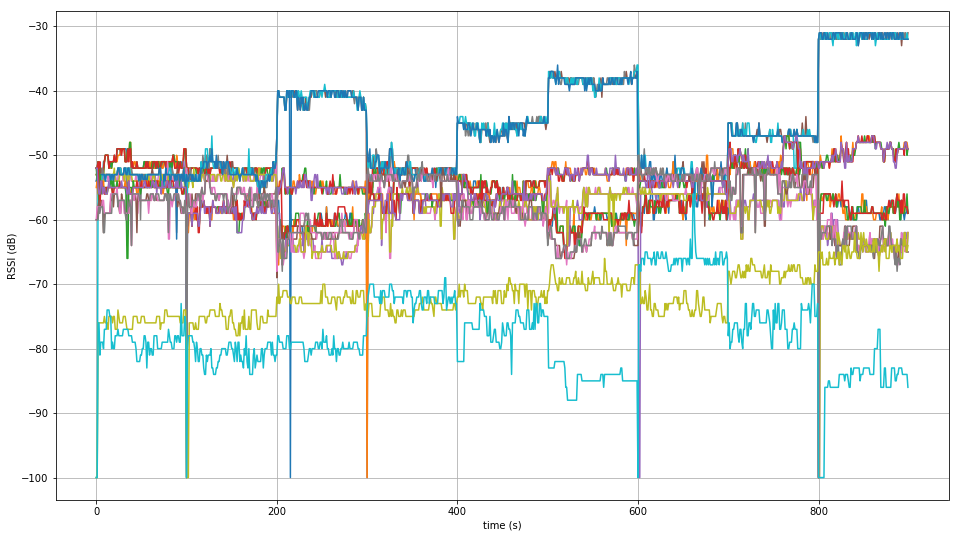

In [177]:
routers = X.T
plt.figure(figsize=(16, 9))
for router in routers:
    plt.plot(router)

plt.xlabel('time (s)')
plt.ylabel('RSSI (dB)')
plt.grid(True)
plt.show()

In [192]:
split = np.array(np.split(routers, 9, axis=1))
split = np.reshape(split, (20, 9, 100))
print(split.shape)

(20, 9, 100)


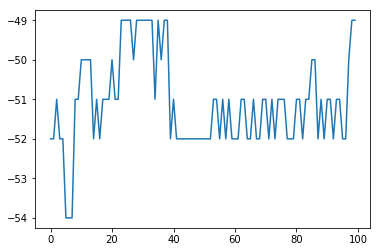

In [193]:
plt.plot(split[0,0])
plt.show()

*Find standard deviation for each router in each location*

In [194]:
stds = np.std(split, axis=2)
print(stds.shape)
print(np.amax(stds))
max_idx = np.unravel_index(np.argmax(stds), stds.shape)
print(stds[max_idx])

(20, 9)
6.59696900099
6.59696900099


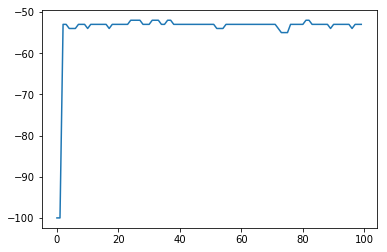

In [195]:
plt.plot(split[max_idx])

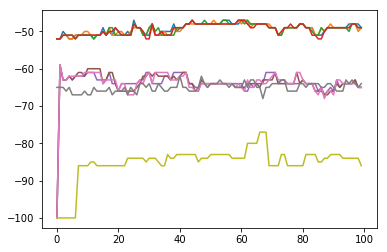

In [196]:
for loc in split[19]:
    plt.plot(loc)
plt.show()

## Scaled Data

In [197]:
def scale_inputs(X, imin=-100, imax=-30, omin=0., omax=1.):
    return (X - imin) * ((omax - omin) / (imax - imin)) + omin
scaled = scale_inputs(routers)

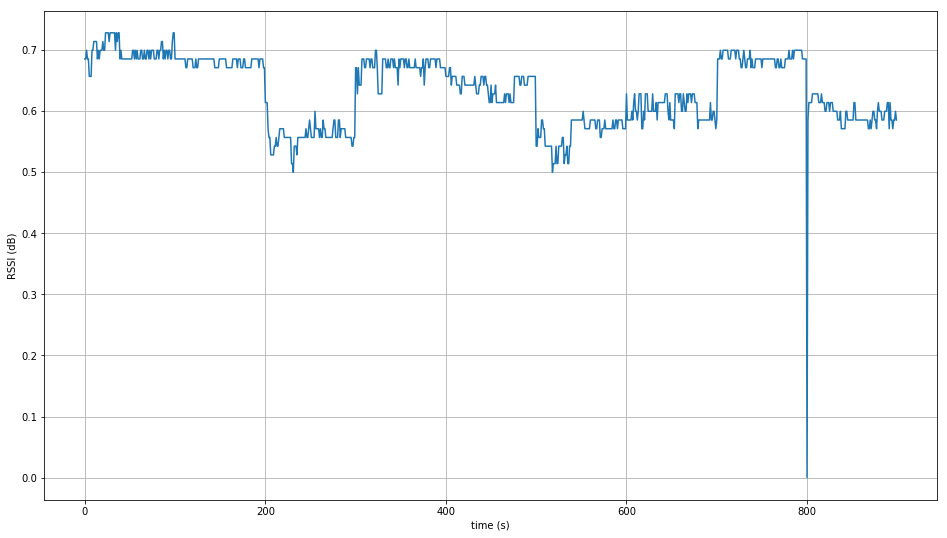

In [208]:
plt.figure(figsize=(16, 9))
for router in scaled[:1]:
    plt.plot(router)

plt.xlabel('time (s)')
plt.ylabel('RSSI (dB)')
plt.grid(True)
plt.show()

*Plot average RSSI per location*

In [205]:
scaled_split = scale_inputs(split)
print(scaled_split.shape)
avgs = np.mean(scaled_split, axis=2)
print(avgs.shape)

(20, 9, 100)
(20, 9)


[ 0.69885714  0.69828571  0.69914286  0.69842857  0.66328571  0.67
  0.66428571  0.66614286  0.66371429]
[ 0.65714286  0.66742857  0.644       0.64057143  0.64442857  0.64428571
  0.607       0.60842857  0.60857143]


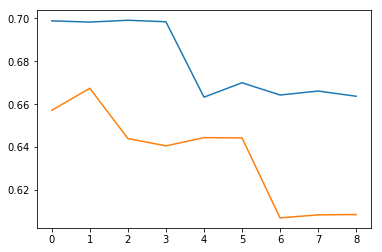

In [219]:
for cell in avgs[:2]:
    print(cell)
    plt.plot(cell)
plt.show()